<a href="https://colab.research.google.com/github/xiekg2020/DL_test/blob/main/4_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import tensorflow as tf
!pip install d2l
from d2l import tensorflow as d2l

     |████████████████████████████████| 81kB 3.6MB/s 


In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    tf.constant(x, dtype=tf.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.8146757],
        [ 1.0192376]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00, -8.1467569e-01,  3.3184823e-01, -9.0116225e-02,
          1.8353874e-02, -2.9904910e-03,  4.0604672e-04, -4.7256628e-05,
          4.8123529e-06, -4.3561189e-07,  3.5488242e-08, -2.6283098e-09,
          1.7843500e-10, -1.1182050e-11,  6.5069602e-13, -3.5340417e-14,
          1.7994362e-15, -8.6232752e-17,  3.9028739e-18, -1.6734612e-19],
        [ 1.0000000e+00,  1.0192376e+00,  5.1942271e-01,  1.7647173e-01,
          4.4966657e-02,  9.1663422e-03,  1.5571135e-03,  2.2672411e-04,
          2.8885717e-05,  3.2712680e-06,  3.3341993e-07,  3.0894014e-08,
          2.6240286e-09,  2.0573145e-10,  1.4977802e-11,  1.0177294e-12,
          6.4831753e-14,  3.8869982e-15,  2.2009860e-16,  1.1806988e-17]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.4944575, 5.513221 ], dtype=

In [4]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), tf.size(l).numpy())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 5.010141   1.2996745 -3.4955077  5.3578343]]


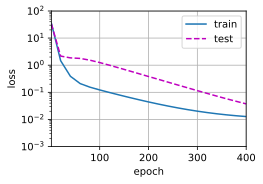

In [6]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.2205188 4.478015 ]]


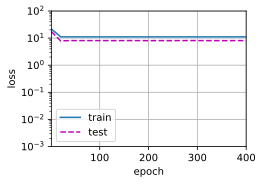

In [7]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9378128e+00  1.3223245e+00 -3.1034415e+00  5.0508971e+00
  -1.1697456e+00  3.5497081e-01 -2.8877079e-01 -4.3578091e-01
   3.6214760e-01 -5.2553463e-01  2.8188044e-01 -4.2862594e-01
  -2.0224416e-01  3.6668899e-03 -1.3661703e-02 -3.4140018e-01
  -2.2750796e-01 -9.4185740e-02 -4.5484298e-01  1.8395019e-01]]


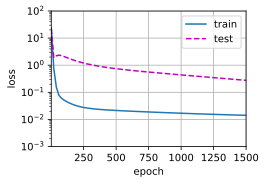

In [8]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)